# Optimización de rutas y flujos en redes complejas

En este cuaderno se van a ver diferentes técnicas o algoritmos para optimizar rutas y flujos en redes complejas. Se van a ver algoritmos de búsqueda de camínos mínimos como A*, o el algoritmos de Johnson, algoritmos para hallar el máximo flujo como Push-Relabel y algoritmos para reducción de grafos como esparcificación dinámica.

Antes de poder implementar todos estos algoritmos, necesitamos una implementación sencilla de grafo para simular las redes.

## Graph Class

In [20]:
class Graph:
    def __init__(self, directed=False):
        """
        Inicializa un grafo vacío.
        :param directed: Booleano, True si el grafo es dirigido.
        """
        self.adj = {}  # Diccionario: nodo -> lista de (vecino, peso)
        self.directed = directed

    def add_edge(self, u, v, weight=1):
        """
        Añade una arista con peso al grafo.
        :param u: Nodo de origen.
        :param v: Nodo de destino.
        :param weight: Peso de la arista.
        """
        if u not in self.adj:
            self.adj[u] = []
        self.adj[u].append((v, weight))

        if not self.directed:
            if v not in self.adj:
                self.adj[v] = []
            self.adj[v].append((u, weight))

    def get_neighbors(self, u):
        """
        Devuelve los vecinos de un nodo.
        :param u: Nodo.
        :return: Lista de tuplas (vecino, peso).
        """
        return self.adj.get(u, [])

    def get_nodes(self):
        """
        Devuelve una lista de todos los nodos del grafo.
        """
        return list(self.adj.keys())

    def get_edges(self):
        """
        Devuelve una lista de todas las aristas: (u, v, peso).
        """
        edges = []
        for u in self.adj:
            for v, w in self.adj[u]:
                if self.directed or (v, u, w) not in edges:
                    edges.append((u, v, w))
        return edges

    def __str__(self):
        """
        Representación amigable del grafo.
        """
        result = []
        for u in self.adj:
            result.append(f"{u}: {self.adj[u]}")
        return "\n".join(result)


## A*

Este es un algoritmo de búsqueda de camino. Es una buena alternativa a Dijkstra debido a su coste temporal. 

## ¿Cómo funciona?

Pues se usan dos funciones:

* g(n): El coste real del camino desde el origen al nodo actual.
* h(n): Una estimación heurística del coste restante hasta el destino.

Luego se obtiene:
$$
f(n) = g(n) + h(n)
$$

En este algoritmo se usa una cola de prioridad. Se comienza inicializando g(start) con 0 y calculando f(start).

# Bucle principal
Mientras la cola no está vacía:
* Obtienes el nodo con menor f(n)
* Si es el destino entonces se termina el bucle.
* Si no, se calculan g, h y f para cada vecino y si se encuentra un mejor camino se actualizan los datos. También se añade a la cola el vecino.


## Complejidad

La complejidad asintótica de A* varía bastante, ya que depende de la heurística a usar. Usando una mala heurística este algoritmo puede llegar a tener la misma complejidad que Dijkstra, la cual es $O(V^2)$. Otra complejidad que es también válida es $O(b^d)$ donde b es el factor de ramificación y d es la profundidad del camino más corto.

## Implementación

In [ ]:
import heapq


def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star(graph, start, goal, heuristic=manhattan_distance):
    open_set = []
    heapq.heappush(open_set, (0, start))

    came_from = {}

    g_score = {node: float('inf') for node in graph.get_nodes()}
    g_score[start] = 0

    f_score = {node: float('inf') for node in graph.get_nodes()}
    f_score[start] = heuristic(start, goal)

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for neighbor, weight in graph.get_neighbors(current):
            tentative_g_score = g_score[current] + weight
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None  

## A* con Fibonacci Heaps

Un Fibonacci heap es una extensión de un Lazy Binomial Heap. Esta estructura está mucho más optimizada que un heap común. Se tienen las siguientes complejidades para sus operaciones:

* insert: O(1)
* find_min: O(1)
* dequeue_min: O(logN)
* decrease_key: O(1)
* delete_node: O(logN)

In [ ]:
from fibonacci_heap_mod import Fibonacci_heap
import math

def a_star_with_fibonacci(graph, start, goal, heuristic=manhattan_distance):
    fib_heap = Fibonacci_heap()
    node_refs = {}

    f_score_start = heuristic(start, goal)
    start_node = fib_heap.enqueue(start, f_score_start)
    node_refs[start] = start_node

    came_from = {}
    g_score = {node: math.inf for node in graph.get_nodes()}
    g_score[start] = 0

    while fib_heap.m_size > 0:
        current = fib_heap.dequeue_min().get_value()

        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for neighbor, weight in graph.get_neighbors(current):
            tentative_g = g_score[current] + weight
            if tentative_g < g_score.get(neighbor, math.inf):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f = tentative_g + heuristic(neighbor, goal)
                if neighbor in node_refs:
                    fib_heap.decrease_key(node_refs[neighbor], f)
                else:
                    neighbor_node = fib_heap.enqueue(neighbor, f)
                    node_refs[neighbor] = neighbor_node

    return None




## Profiling A*

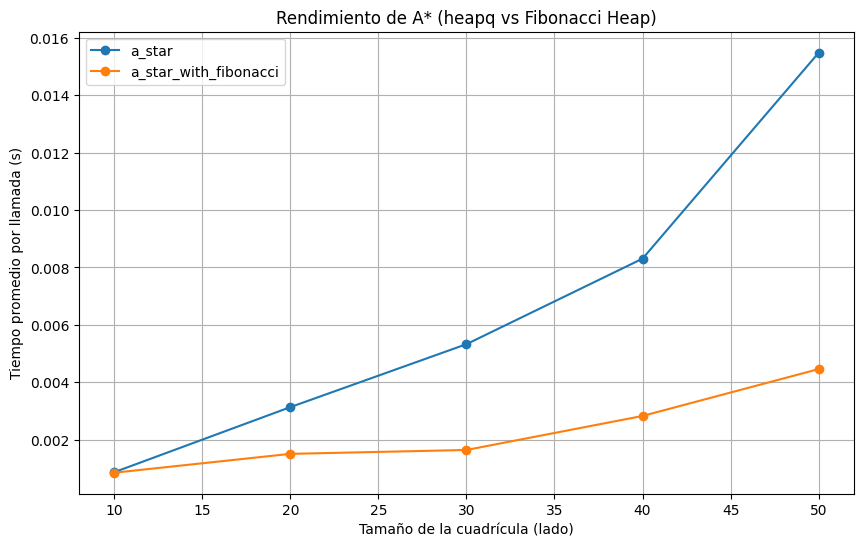

In [ ]:
import cProfile
import pstats
import os
import pandas as pd
import matplotlib.pyplot as plt


if not os.path.exists('data'):
    os.makedirs('data', exist_ok=True)

OUTPUT_CSV = 'data/stats_astar.csv'

SIZES = [10, 20, 30, 40, 50]
RUNS = 3  

def generate_grid_graph(rows, cols):
    g = Graph(directed=False)
    for i in range(rows):
        for j in range(cols):
            if i < rows - 1:
                g.add_edge((i, j), (i + 1, j), 1)
            if j < cols - 1:
                g.add_edge((i, j), (i, j + 1), 1)
    return g

def profile_function(func, *args):
    profiler = cProfile.Profile()
    profiler.runcall(func, *args)
    stats = pstats.Stats(profiler)
    return stats

def write_header(f):
    f.write('size,method_name,total_time,cumulative_time,per_call_time\n')

def write_row(f, size, method_name, total_time, cumulative_time, per_call_time):
    f.write(f'{size},{method_name},{total_time},{cumulative_time},{per_call_time}\n')

def get_stats(stats, target_method):
    ps = stats.strip_dirs().stats

    def is_method(k):
        return target_method in k[2]

    keys = list(filter(is_method, ps.keys()))
    return [(key[2], ps[key][2], ps[key][3], ps[key][3] / ps[key][1]) for key in keys]

def main():
    with open(OUTPUT_CSV, 'w') as f:
        write_header(f)
        for size in SIZES:
            for _ in range(RUNS):
                g = generate_grid_graph(size, size)
                start = (0, 0)
                goal = (size - 1, size - 1)

                # Profiling A* con heap común
                stats1 = profile_function(a_star, g, start, goal, manhattan_distance)
                for method_name, total, cumulative, per_call in get_stats(stats1, 'a_star'):
                    write_row(f, size, method_name, total, cumulative, per_call)

                # Profiling A* con Fibonacci Heap
                stats2 = profile_function(a_star_with_fibonacci, g, start, goal, manhattan_distance)
                for method_name, total, cumulative, per_call in get_stats(stats2, 'a_star_with_fibonacci'):
                    write_row(f, size, method_name, total, cumulative, per_call)

def plot_results(csv_file):
    df = pd.read_csv(csv_file)
    grouped = df.groupby(['size', 'method_name']).agg({
        'per_call_time': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    for method in grouped['method_name'].unique():
        data = grouped[grouped['method_name'] == method]
        plt.plot(data['size'], data['per_call_time'], marker='o', label=method)

    plt.title('Rendimiento de A* (heapq vs Fibonacci Heap)')
    plt.xlabel('Tamaño de la cuadrícula (lado)')
    plt.ylabel('Tiempo promedio por llamada (s)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
    plot_results(OUTPUT_CSV)




## Pruebas unitarias A*

In [ ]:
import unittest
import math

class TestAStar(unittest.TestCase):
    def setUp(self):
        self.g = Graph(directed=False)
        for i in range(3):
            for j in range(3):
                if i < 2:
                    self.g.add_edge((i, j), (i + 1, j), 1)
                if j < 2:
                    self.g.add_edge((i, j), (i, j + 1), 1)

    def test_astar_heapq(self):
        start = (0, 0)
        goal = (2, 2)
        path = a_star(self.g, start, goal, heuristic=manhattan_distance)
        self.assertIsNotNone(path)
        self.assertEqual(path[0], start)
        self.assertEqual(path[-1], goal)
        self.assertEqual(len(path), 5)

    def test_astar_fibonacci(self):
        start = (0, 0)
        goal = (2, 2)
        path = a_star_with_fibonacci(self.g, start, goal, heuristic=manhattan_distance)
        self.assertIsNotNone(path)
        self.assertEqual(path[0], start)
        self.assertEqual(path[-1], goal)
        self.assertEqual(len(path), 5)

    def test_unreachable_node_heapq(self):
        isolated = (3, 3)
        self.g.add_edge(isolated, isolated, 0)
        path = a_star(self.g, (0, 0), isolated, heuristic=manhattan_distance)
        self.assertIsNone(path)

    def test_unreachable_node_fibonacci(self):
        isolated = (3, 3)
        self.g.add_edge(isolated, isolated, 0)
        path = a_star_with_fibonacci(self.g, (0, 0), isolated, heuristic=manhattan_distance)
        self.assertIsNone(path)

    def test_larger_graph_heapq(self):
        g_large = Graph(directed=False)
        for i in range(10):
            for j in range(10):
                if i < 9:
                    g_large.add_edge((i, j), (i + 1, j), 1)
                if j < 9:
                    g_large.add_edge((i, j), (i, j + 1), 1)
        path = a_star(g_large, (0, 0), (9, 9), heuristic=manhattan_distance)
        self.assertIsNotNone(path)
        self.assertEqual(path[0], (0, 0))
        self.assertEqual(path[-1], (9, 9))

    def test_larger_graph_fibonacci(self):
        g_large = Graph(directed=False)
        for i in range(10):
            for j in range(10):
                if i < 9:
                    g_large.add_edge((i, j), (i + 1, j), 1)
                if j < 9:
                    g_large.add_edge((i, j), (i, j + 1), 1)
        path = a_star_with_fibonacci(g_large, (0, 0), (9, 9), heuristic=manhattan_distance)
        self.assertIsNotNone(path)
        self.assertEqual(path[0], (0, 0))
        self.assertEqual(path[-1], (9, 9))

def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestAStar)
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(suite)
    return result

run_tests()


test_astar_fibonacci (__main__.TestAStar.test_astar_fibonacci) ... ok
test_astar_heapq (__main__.TestAStar.test_astar_heapq) ... ok
test_larger_graph_fibonacci (__main__.TestAStar.test_larger_graph_fibonacci) ... ok
test_larger_graph_heapq (__main__.TestAStar.test_larger_graph_heapq) ... ok
test_unreachable_node_fibonacci (__main__.TestAStar.test_unreachable_node_fibonacci) ... ok
test_unreachable_node_heapq (__main__.TestAStar.test_unreachable_node_heapq) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.013s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

## Push-Relabel

Este algoritmo es una buena alternativa al algoritmo de Ford Fulkerson, debido a su mejora en rendimiento.

La complejidad temporal es de $O(V^2E)$, aunque incluso hay un enfoque que llega a mejorarla, haciéndola $O(V^3)$

Al igual que en Fordk Fulkerson, se usa un grafo residual, sin embargo, la mayor diferencia es que este algoritmo trabaja sobre cada eje en vez de trabajar sobre toda la red residual.

## Concepto clave

Consideramos que source está en el nivel más alto y envía flujo a todos sus nodos adyacentes. Una vez que un nodo tiene exceso de flujo, lo envía a un nodo de menor nivel. Si en uno de estos casos no hay nodos de menor nivel, entonces se hace un relabel, se cambia la altura al nodo actual para que pueda tener nodos con menor altura, y se procede a hacer el push().

In [ ]:
def push_relabel_max_flow(graph, source, sink):
    residual = {}
    for u in graph.get_nodes():
        residual[u] = {}
        for v, w in graph.get_neighbors(u):
            residual[u][v] = w
            if v not in residual:
                residual[v] = {}
            if u not in residual[v]:
                residual[v][u] = 0

    for u in list(residual.keys()):
        for v in residual[u]:
            if v not in residual:
                residual[v] = {}
            if u not in residual[v]:
                residual[v][u] = 0

    all_nodes = list(residual.keys())
    height = {node: 0 for node in all_nodes}
    excess = {node: 0 for node in all_nodes}
    height[source] = len(all_nodes)

    for v, capacity in graph.get_neighbors(source):
        residual[source][v] = 0
        residual[v][source] = capacity
        excess[v] = capacity
        excess[source] -= capacity

    active = [u for u in all_nodes if u != source and u != sink and excess[u] > 0]

    def push(u, v):
        send = min(excess[u], residual[u][v])
        residual[u][v] -= send
        if u not in residual[v]:
            residual[v][u] = 0
        residual[v][u] += send
        excess[u] -= send
        excess[v] += send
        if v != source and v != sink and excess[v] == send:
            active.append(v)

    def relabel(u):
        min_height = float('inf')
        for v in residual[u]:
            if residual[u][v] > 0:
                min_height = min(min_height, height[v])
        if min_height < float('inf'):
            height[u] = min_height + 1

    index = 0
    while index < len(active):
        u = active[index]
        pushed = False
        for v in residual[u]:
            if residual[u][v] > 0 and height[u] == height[v] + 1:
                push(u, v)
                pushed = True
                if excess[u] == 0:
                    break
        if not pushed:
            relabel(u)
            index = 0
        else:
            index += 1

    flow = sum(residual[v][source] for v in residual if source in residual[v])
    return flow

if __name__ == "__main__":
    g = Graph(directed=True)
    g.add_edge("s", "a", 16)
    g.add_edge("s", "c", 13)
    g.add_edge("a", "b", 12)
    g.add_edge("b", "c", 10)
    g.add_edge("c", "a", 4)
    g.add_edge("b", "t", 20)
    g.add_edge("c", "d", 14)
    g.add_edge("d", "b", 7)
    g.add_edge("d", "t", 4)

    max_flow = push_relabel_max_flow(g, "s", "t")
    print("Flujo máximo:", max_flow)



Flujo máximo: 25


In [ ]:
import unittest

class TestPushRelabel(unittest.TestCase):

    def test_basic_flow(self):
        g = Graph(directed=True)
        g.add_edge("s", "a", 16)
        g.add_edge("s", "c", 13)
        g.add_edge("a", "b", 12)
        g.add_edge("b", "c", 10)
        g.add_edge("c", "a", 4)
        g.add_edge("b", "t", 20)
        g.add_edge("c", "d", 14)
        g.add_edge("d", "b", 7)
        g.add_edge("d", "t", 4)

        max_flow = push_relabel_max_flow(g, "s", "t")
        self.assertEqual(max_flow, 25) 

    def test_no_path(self):
        g = Graph(directed=True)
        g.add_edge("s", "a", 10)
        g.add_edge("a", "b", 5)
        max_flow = push_relabel_max_flow(g, "s", "t")
        self.assertEqual(max_flow, 0)

    def test_single_edge(self):
        g = Graph(directed=True)
        g.add_edge("s", "t", 10)
        max_flow = push_relabel_max_flow(g, "s", "t")
        self.assertEqual(max_flow, 10)

    def test_multiple_paths(self):
        g = Graph(directed=True)
        g.add_edge("s", "a", 10)
        g.add_edge("a", "t", 5)
        g.add_edge("s", "b", 10)
        g.add_edge("b", "t", 15)
        max_flow = push_relabel_max_flow(g, "s", "t")
        self.assertEqual(max_flow, 15)


    def test_bidirectional_edges(self):
        g = Graph(directed=True)
        g.add_edge("s", "a", 10)
        g.add_edge("a", "s", 5)
        g.add_edge("a", "t", 10)
        g.add_edge("t", "a", 5)
        max_flow = push_relabel_max_flow(g, "s", "t")
        self.assertEqual(max_flow, 10)

def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestPushRelabel)
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(suite)
    return result

run_tests()


test_basic_flow (__main__.TestPushRelabel.test_basic_flow) ... ok
test_bidirectional_edges (__main__.TestPushRelabel.test_bidirectional_edges) ... ok
test_multiple_paths (__main__.TestPushRelabel.test_multiple_paths) ... ok
test_no_path (__main__.TestPushRelabel.test_no_path) ... ok
test_single_edge (__main__.TestPushRelabel.test_single_edge) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.013s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

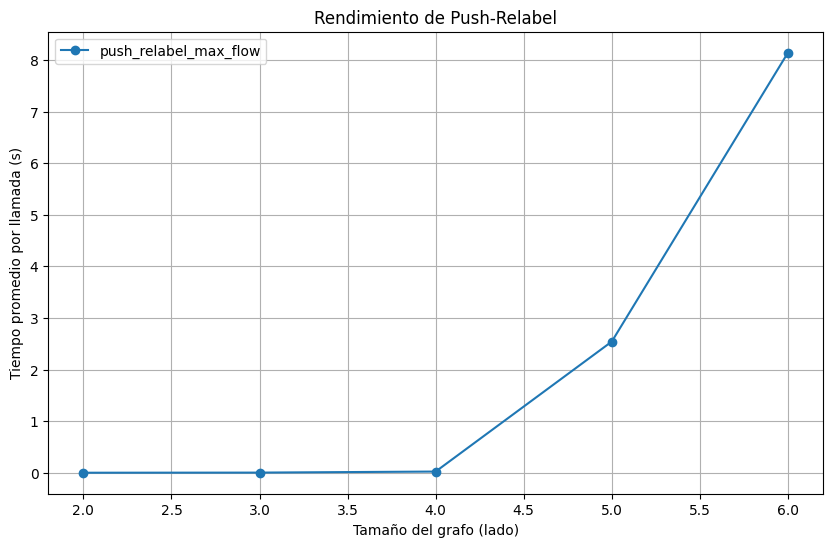

In [ ]:
import cProfile
import pstats
import os
import pandas as pd
import matplotlib.pyplot as plt

if not os.path.exists('data'):
    os.makedirs('data', exist_ok=True)

OUTPUT_CSV = 'data/stats_pushrelabel.csv'

SIZES = [2, 3, 4, 5, 6]
RUNS = 3

def generate_grid_graph(rows, cols):
    g = Graph(directed=True)
    for i in range(rows):
        for j in range(cols):
            if i < rows - 1:
                g.add_edge((i, j), (i+1, j), 1)
            if j < cols - 1:
                g.add_edge((i, j), (i, j+1), 1)
    return g

def profile_function(func, *args):
    profiler = cProfile.Profile()
    profiler.runcall(func, *args)
    stats = pstats.Stats(profiler)
    return stats

def write_header(f):
    f.write('size,method_name,total_time,cumulative_time,per_call_time\n')

def write_row(f, size, method_name, total_time, cumulative_time, per_call_time):
    f.write(f'{size},{method_name},{total_time},{cumulative_time},{per_call_time}\n')

def get_stats(stats, target_method):
    ps = stats.strip_dirs().stats
    def is_method(k):
        return target_method in k[2]
    keys = list(filter(is_method, ps.keys()))
    return [(key[2], ps[key][2], ps[key][3], ps[key][3] / ps[key][1]) for key in keys]

def main():
    with open(OUTPUT_CSV, 'w') as f:
        write_header(f)
        for size in SIZES:
            for _ in range(RUNS):
                g = generate_grid_graph(size, size)
                start = (0, 0)
                goal = (size-1, size-1)

                stats = profile_function(push_relabel_max_flow, g, start, goal)
                for method_name, total, cumulative, per_call in get_stats(stats, 'push_relabel_max_flow'):
                    write_row(f, size, method_name, total, cumulative, per_call)

def plot_results(csv_file):
    df = pd.read_csv(csv_file)
    grouped = df.groupby(['size', 'method_name']).agg({
        'per_call_time': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    for method in grouped['method_name'].unique():
        data = grouped[grouped['method_name'] == method]
        plt.plot(data['size'], data['per_call_time'], marker='o', label=method)

    plt.title('Rendimiento de Push-Relabel')
    plt.xlabel('Tamaño del grafo (lado)')
    plt.ylabel('Tiempo promedio por llamada (s)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
    plot_results(OUTPUT_CSV)


## Dynamic sparsification

Esta es una técnica en la que reduces un grafo de forma dinámica para que no sea tan denso. El objetivo es tener un grafo más pequeño sin perder las propiedades del grafo original. Esto va a aumentar la velocidad para muchos algoritmos al trabajar con estos grafos.

## Concepto clave

- Se obtiene el grafo con menos aristas que el original usando diferentes técnicas con tal de que se preserven sus propiedades. Este se va a llamar sparsifier
- Al actualizarse el grafo se actualiza el sparsifier sin tener que reconstruirlo desde cero.

Hay muchas maneras de implementar esto, una muy sencilla y poco eficiente podría ser la siguiente:

In [89]:
def generate_sparsifier(graph, weight_threshold):
    new_graph = Graph(directed=graph.directed)
    for u, v, w in graph.get_edges():
        if w <= weight_threshold:
            new_graph.add_edge(u, v, w)
    return new_graph

La mayoría de implementaciones son algo complejas, tanto que son vistas mayormente en papers o tesis. A continuación adjunto algunos papers que encontré interesantes:

* [DynamicVit: Efficient Vision Transformers with Dynamic Token Sparsification](https://proceedings.neurips.cc/paper/2021/hash/747d3443e319a22747fbb873e8b2f9f2-Abstract.html)

* [Dynamic Spatial Sparsification for Efficient Vision Transformers and Convolutional Neural Networks](https://arxiv.org/abs/2207.01580)